In [1]:
##Estimación de indicadores de población ocupada en cultura
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,httr,utils)

Loading required package: pacman



In [2]:
font_add_google("Roboto", "rob")
showtext_auto()

In [3]:
# Función para descargar los datos de la ENOE en formato CSV
descargar_enoe_csv <- function() {
  # Crear directorio de trabajo si no existe
  if (!dir.exists("datos")) {
    dir.create("datos")
  }
  if (!dir.exists("datos/enoe")) {
    dir.create("datos/enoe")
  }

  # Cambiar al directorio de trabajo
  setwd("datos/enoe")

  # Función para descargar y extraer archivos
  descargar_extraer <- function(url) {
    temp <- tempfile()
    download.file(url, temp, mode = "wb")
    unzip(temp)
    unlink(temp)
  }

  # Descargar datos de 2005 a 2009
  for (i in 7:9) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/200", i, "trim4_csv.zip")
    descargar_extraer(url)
  }

  # Descargar datos de 2010 a 2019
  for (i in 10:19) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/20", i, "trim4_csv.zip")
    print(url)
    descargar_extraer(url)
  }

  # Descargar datos de 2020
  for (i in 20:20) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/enoe_n_20", i, "_trim4_csv.zip")
    descargar_extraer(url)
  }

  # Descargar datos de 2021 a 2022
  for (i in 21:22) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/enoe_n_20", i, "_trim4_csv.zip")
    descargar_extraer(url)
  }

  # Descargar datos de 2023
  for (i in 23:23) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/enoe_20", i, "_trim4_csv.zip")
    descargar_extraer(url)
  }

  # Eliminar archivos innecesarios (conservar solo SDEMT y COE1T)
  # Listar archivos con extensión .csv, sin importar mayúsculas/minúsculas
  archivos <- list.files(pattern = "\\.csv$", ignore.case = TRUE)

  # Lista de archivos a eliminar (que NO contienen "SDEMT" o "COE1T", sin importar mayúsculas/minúsculas)
  archivos_a_eliminar <- archivos[!grepl("sdemt|coe1t", archivos, ignore.case = TRUE)]
  file.remove(archivos_a_eliminar)

  # Eliminar archivo zip (si existe)
  if (file.exists("archivos.zip")) {
    file.remove("archivos.zip")
  }

  # Regresar al directorio original
  setwd("../..")
}

In [4]:
descargar_enoe_csv()

[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2010trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2011trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2012trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2013trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2014trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2015trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2016trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2017trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2018trim4_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/microdatos/2019trim4_csv.zip"


In [5]:
# Función para extraer el año desde el nombre del archivo
extraer_anio <- function(path) {
  anio_str <- str_extract(path, "\\d{2}(?=\\D*$)") # Extrae los últimos dos dígitos del año
  anio <- as.numeric(paste0("20", anio_str)) # Convierte a formato 20XX
  return(anio)
}

In [6]:
# Función para procesar la ENOE con ajuste para `tipo`
estima_empleo_cultura <- function(sdemt_path, coe1t_path, tipo_empleo = "empleo_cultural_federal") {
  year <- extraer_anio(sdemt_path)

  # Leer y filtrar ocupados
  ocupados <- read_csv(sdemt_path, show_col_types = FALSE) %>%
    janitor::clean_names() %>%
    filter(
      clase2 == 1,
      (eda >= 15 & eda <= 98 & !is.na(eda)) & (c_res == 1 | c_res == 3)
    ) %>%
    mutate(year = year) # Agregar el año

  # Leer COE1T y seleccionar columnas según el año
  sinco <- read_csv(coe1t_path, show_col_types = FALSE) %>%
    janitor::clean_names() %>%
    { if (year <= 2019) select(., cd_a, ent, con, v_sel, n_hog, h_mud, n_ren, p3) else
        select(., tipo, mes_cal, cd_a, ent, con, v_sel, n_hog, h_mud, n_ren, p3) } %>%
    rename(sinco = p3)

  # Hacer el `left_join()` sin `tipo` si el año está entre 2005 y 2019
  if (year <= 2019) {
    ocupados <- left_join(ocupados, sinco, by = c("cd_a", "ent", "con", "v_sel", "n_hog", "h_mud", "n_ren"))
  } else {
    ocupados <- left_join(ocupados, sinco, by = c("tipo", "mes_cal", "cd_a", "ent", "con", "v_sel", "n_hog", "h_mud", "n_ren"))
  }

  # Clasificación de empleo cultural
  ocupados <- ocupados %>%
    mutate(
      cultura_federal = ifelse(sinco %in% c(
        2175, 7611, 2552, 2131, 7313, 7342, 7321, 2174, 7343, 2173, 2171, 1721, 1722,
        2544, 2271, 2625, 2162, 1422, 1322, 1421, 2541, 2543, 2542, 2164, 2151, 2163, 2144, 2425, 2655, 3222, 7322, 2712,
        7223, 2551, 5212, 2636, 4233, 2172, 8155, 8144, 7999, 7344, 2553, 7352, 2152, 2161, 7323, 7201, 7601, 7401, 7301,
        2652, 7332, 9713, 4312, 7614, 7353
      ), 1, 0),
      cultura_cdmx = ifelse(sinco %in% c(
        2175, 7611, 2552, 2131, 7313, 7342, 7321, 2174, 7343, 2173, 2171, 1721, 1722,
        2544, 2271, 2625, 2162, 1422, 1322, 1421, 2541, 2543, 2542, 2164, 2151, 2163, 2144, 2425, 2655, 3222, 7322, 2712,
        7223, 2551, 5212, 2636, 4233, 2172, 8155, 8144, 7999, 7344, 2553, 7352, 2152, 2161, 7323, 7201, 7601, 7401, 7301,
        2652, 7332, 9713, 4312, 7614, 7353, 2514, 5212, 2653, 2654, 7299, 7999, 7311, 7331, 7341, 7411, 7412, 9234, 9235,
        9237, 4233, 2141, 2153, 2339, 2334, 2715, 1412, 1712, 3221, 5101, 5111, 5112, 5113, 5114, 5115, 5116, 5119, 7515, 7517, 9411
      ), 1, 0),
             cultura_cdmx_st = ifelse(sinco %in% c(
        2175, 7611, 2552, 2131, 7313, 7342, 7321, 2174, 7343, 2173, 2171, 1721, 1722,
        2544, 2271, 2625, 2162, 1422, 1322, 1421, 2541, 2543, 2542, 2164, 2151, 2163, 2144, 2425, 2655, 3222, 7322, 2712,
        7223, 2551, 5212, 2636, 4233, 2172, 8155, 8144, 7999, 7344, 2553, 7352, 2152, 2161, 7323, 7201, 7601, 7401, 7301,
        2652, 7332, 9713, 4312, 7614, 7353, 2514, 5212, 2653, 2654, 7299, 7999, 7311, 7331, 7341, 7411, 7412, 9234, 9235,
        9237, 4233, 2141, 2153, 2339, 2334, 2715
      ), 1, 0)

    )

  # Crear diseño de encuesta
  options(survey.lonely.psu = "certainty")
  if (year <= 2019) {
    dm <- ocupados %>%
      as_survey_design(
        ids = upm,
        strata = est_d,
        weights = fac,
        nest = TRUE
      )
  } else {
    dm <- ocupados %>%
      as_survey_design(
        ids = upm,
        strata = est_d_tri,
        weights = fac_tri,
        nest = TRUE
      )
  }
  # Filtrar y calcular ocupados por tipo de empleo
  resultado <- if (tipo_empleo == "empleo_cultural_federal") {
    dm %>%
      filter(ent == 9) %>%
      group_by(cultura_federal) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = porcentaje * 100) %>%
      filter(cultura_federal == 1)%>%
                mutate(year = year)
  } else if (tipo_empleo == "empleo_cultural_cdmx") {
    dm %>%
      filter(ent == 9) %>%
      group_by(cultura_cdmx) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = porcentaje * 100) %>%
      filter(cultura_cdmx == 1)%>%
              mutate(year = year)
  } else if (tipo_empleo == "empleo_cultural_cdmx_st") {
    dm %>%
      filter(ent == 9) %>%
      group_by(cultura_cdmx_st) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = porcentaje * 100) %>%
      filter(cultura_cdmx_st == 1)%>%
              mutate(year = year)

  }

            else {
    stop("El parámetro 'tipo_empleo' debe ser 'empleo_cultural_federal', 'empleo_cultural_cdmx' o 'empleo_cultural_cdmx_st'")
  }

  return(resultado)
}

In [7]:
lista_archivos <- list.files(path = "datos/enoe", full.names = TRUE)

In [8]:
archivos_sdemt <- lista_archivos[str_detect(lista_archivos, regex("sdemt", ignore_case = TRUE))]
archivos_coe1t <- lista_archivos[str_detect(lista_archivos, regex("coe1t", ignore_case = TRUE))]

In [9]:
# Crear un data frame con los nombres de archivos y sus años
df_archivos <- tibble(
  sdemt = archivos_sdemt,
  year = map_int(archivos_sdemt, extraer_anio)
) %>%
  left_join(
    tibble(
      coe1t = archivos_coe1t,
      year = map_int(archivos_coe1t, extraer_anio)
    ),
    by = "year"
  ) %>%
  filter(!is.na(sdemt) & !is.na(coe1t))%>%
        arrange(year)
df_archivos

sdemt,year,coe1t
<chr>,<int>,<chr>
datos/enoe/SDEMT407.csv,2007,datos/enoe/COE1T407.csv
datos/enoe/SDEMT408.csv,2008,datos/enoe/COE1T408.csv
datos/enoe/SDEMT409.csv,2009,datos/enoe/COE1T409.csv
datos/enoe/SDEMT410.csv,2010,datos/enoe/COE1T410.csv
datos/enoe/SDEMT411.csv,2011,datos/enoe/COE1T411.csv
datos/enoe/sdemt412.csv,2012,datos/enoe/coe1t412.csv
datos/enoe/sdemt413.csv,2013,datos/enoe/coe1t413.csv
datos/enoe/SDEMT414.csv,2014,datos/enoe/COE1T414.csv
datos/enoe/SDEMT415.csv,2015,datos/enoe/COE1T415.csv


In [10]:
#Estima empleo cultural de la Ciudad de México con metodología de cultura de la Ciudad de México
print("Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura cdmx")
empleo_cultural_cdmx <- df_archivos %>%
        select(-year) %>%
  mutate(data = map2(sdemt, coe1t, ~ estima_empleo_cultura(.x, .y, "empleo_cultural_cdmx"))) %>%
  unnest(data)%>%
        select(year,ocupados,ocupados_cv,porcentaje,porcentaje_cv)%>%
        mutate(porcentaje=round(porcentaje,2))
empleo_cultural_cdmx

[1] "Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura cdmx"


Warning message:
"There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `data = map2(sdemt, coe1t, ~estima_empleo_cultura(.x, .y,
  "empleo_cultural_cdmx"))`.
Caused by warning:
! One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings."


year,ocupados,ocupados_cv,porcentaje,porcentaje_cv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007,129427,0.09928315,3.26,0.09748795
2008,138792,0.09301033,3.61,0.09222328
2009,129733,0.09524193,3.32,0.09440508
2010,143190,0.10276259,3.67,0.10191412
2011,174559,0.10103369,4.23,0.09944722
2012,596174,0.04817791,14.12,0.04485467
2013,595932,0.04475438,14.05,0.04280903
2014,570175,0.04900231,13.78,0.04719061
2015,521777,0.05199346,12.18,0.04905067


In [11]:
#Estima empleo cultural de la Ciudad de México con metodología de cultura de la Ciudad de México
print("Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura cdmx sin turismo")
empleo_cultural_cdmx_st <- df_archivos %>%
        select(-year) %>%
  mutate(data = map2(sdemt, coe1t, ~ estima_empleo_cultura(.x, .y, "empleo_cultural_cdmx_st"))) %>%
  unnest(data)%>%
        select(year,ocupados,ocupados_cv,porcentaje,porcentaje_cv)%>%
        mutate(porcentaje=round(porcentaje,2))
empleo_cultural_cdmx_st

[1] "Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura cdmx sin turismo"


Warning message:
"There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `data = map2(sdemt, coe1t, ~estima_empleo_cultura(.x, .y,
  "empleo_cultural_cdmx_st"))`.
Caused by warning:
! One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings."


year,ocupados,ocupados_cv,porcentaje,porcentaje_cv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007,117324,0.10615912,2.96,0.10408597
2008,124978,0.09589698,3.25,0.09511627
2009,122125,0.09671641,3.12,0.09559326
2010,131453,0.10765648,3.37,0.10661937
2011,162777,0.10686320,3.95,0.10506053
2012,341868,0.06424250,8.10,0.06213111
2013,336024,0.05917835,7.92,0.05783600
2014,273731,0.06582635,6.62,0.06539734
2015,302599,0.06784081,7.07,0.06559345


In [12]:
#Estima empleo cultural de la Ciudad de México con metodología de cultura de la Ciudad de México
print("Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura federal")
empleo_cultural_federal <- df_archivos %>%
        select(-year) %>%
  mutate(data = map2(sdemt, coe1t, ~ estima_empleo_cultura(.x, .y, "empleo_cultural_federal"))) %>%
  unnest(data)%>%
        select(year,ocupados,ocupados_cv,porcentaje,porcentaje_cv)%>%
                mutate(porcentaje=round(porcentaje,2))
empleo_cultural_federal

[1] "Población ocupada en cultura en la Ciudad de México de acuerdo a metodología de cultura federal"


Warning message:
"There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `data = map2(sdemt, coe1t, ~estima_empleo_cultura(.x, .y,
  "empleo_cultural_federal"))`.
Caused by warning:
! One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings."


year,ocupados,ocupados_cv,porcentaje,porcentaje_cv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007,117324,0.10615912,2.96,0.10408597
2008,124978,0.09589698,3.25,0.09511627
2009,122125,0.09671641,3.12,0.09559326
2010,131453,0.10765648,3.37,0.10661937
2011,162777,0.10686320,3.95,0.10506053
2012,219322,0.08215224,5.19,0.08005495
2013,220271,0.07212605,5.19,0.07125053
2014,172786,0.08501462,4.18,0.08497808
2015,197084,0.08634617,4.60,0.08474294


### Metas

In [13]:
predecir_empleo_cultural <- function(df_predict, titulo="Proyección de empleo cultural", nombre_archivo="proyeccion_empleo.png") {
  # Ajustar modelo de regresión lineal
  model <- lm(porcentaje ~ year, data = df_predict)
  print(summary(model))

  # Crear datos futuros
  future_years <- data.frame(year = 2024:2045)

  # Hacer predicciones
  future_predictions <- predict(model, newdata = future_years)

  # Crear data frame con predicciones
  predictions_df <- data.frame(
    year = future_years$year,
    porcentaje = future_predictions
  )

  # Unir los datos originales con las predicciones
  df_final <- bind_rows(df_predict, predictions_df)

  # Mostrar valores 2030, 2035 y 2045
  print("Metas del indicador")
print(df_final %>%
        filter(year %in% c(2030, 2035, 2045)) %>%
        mutate(porcentaje = sprintf("%.2f", porcentaje)) %>%  # Formatear a dos decimales
        select(year, porcentaje))

  # Generar gráfico
  grafico <- ggplot(df_final, aes(x = year, y = porcentaje)) +
    geom_line(color="#9f2241",linewidth=1.5) +
    labs(title = titulo, x = "Año", y = "Porcentaje") +
    geom_vline(xintercept = c(2024), linetype = "dashed", color = "red") +
          theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0, size=20, face="bold"),
      plot.subtitle = element_text(hjust = 0, size=15, face="italic"),
      plot.caption = element_text(hjust = 0, size=10),
      legend.position = "right",
      legend.text = element_text(size=18),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18),
      legend.title = element_text(size=18),
      text = element_text(family="rob")
    )

  # Guardar la gráfica en un archivo
  ggsave(nombre_archivo, plot = grafico, width = 10, height = 6, dpi = 100,bg="white")

  return(grafico)
}


Call:
lm(formula = porcentaje ~ year, data = df_predict)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4682 -2.4340 -0.1579  1.2659  5.6178 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1609.0866   287.4729  -5.597 5.09e-05 ***
year            0.8040     0.1427   5.635 4.74e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.882 on 15 degrees of freedom
Multiple R-squared:  0.6792,	Adjusted R-squared:  0.6578 
F-statistic: 31.76 on 1 and 15 DF,  p-value: 4.743e-05

[1] "Metas del indicador"
# A tibble: 3 × 2
   year porcentaje
  <dbl> <chr>     
1  2030 22.97     
2  2035 26.99     
3  2045 35.03     


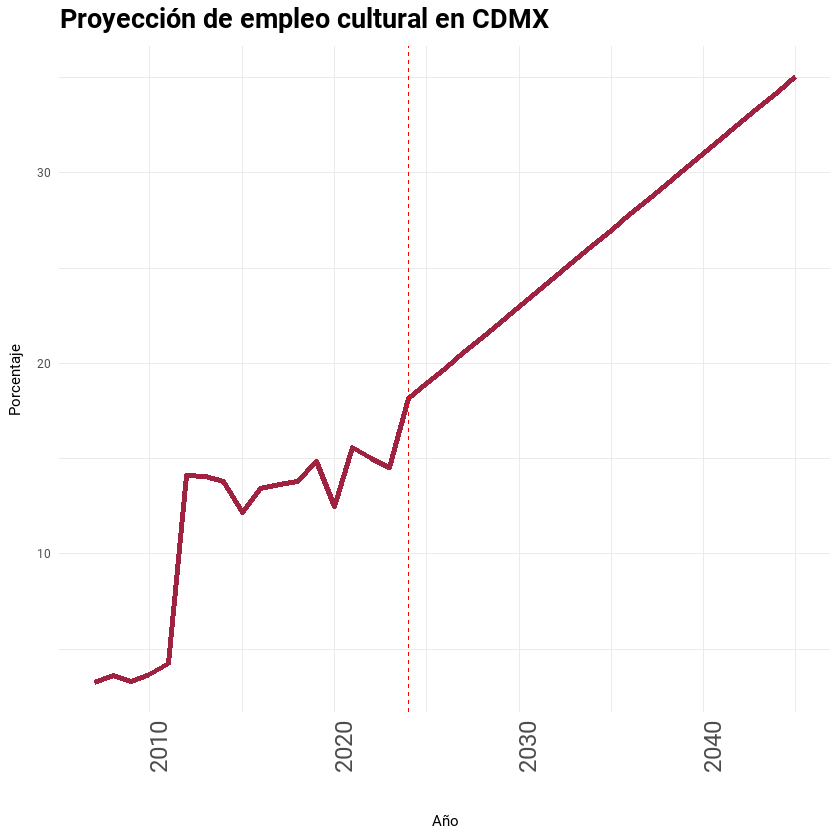

In [14]:
# empleo_cultural_cdmx
predecir_empleo_cultural(empleo_cultural_cdmx, "Proyección de empleo cultural en CDMX", "proyeccion_empleo_cdmx.png")


Call:
lm(formula = porcentaje ~ year, data = df_predict)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.39059 -0.89059 -0.02059  0.49941  2.69941 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -718.91941  120.08130  -5.987 2.49e-05 ***
year           0.36000    0.05959   6.041 2.26e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.204 on 15 degrees of freedom
Multiple R-squared:  0.7087,	Adjusted R-squared:  0.6893 
F-statistic: 36.49 on 1 and 15 DF,  p-value: 2.26e-05

[1] "Metas del indicador"
# A tibble: 3 × 2
   year porcentaje
  <dbl> <chr>     
1  2030 11.88     
2  2035 13.68     
3  2045 17.28     


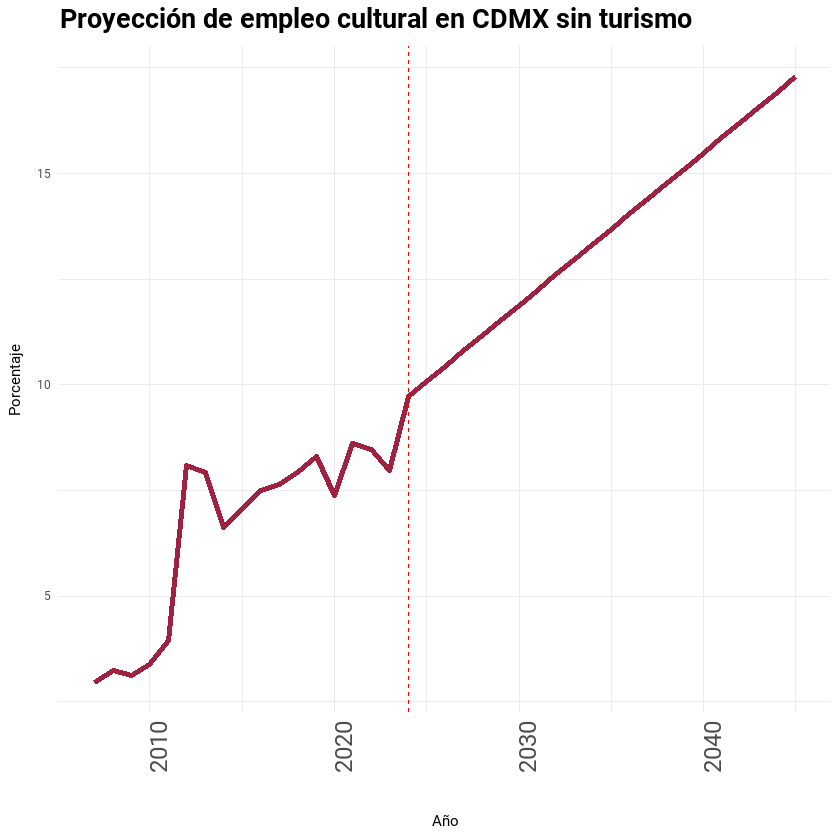

In [15]:
# Ejemplo de uso con empleo_cultural_cdmx
predecir_empleo_cultural(empleo_cultural_cdmx_st, "Proyección de empleo cultural en CDMX sin turismo", "proyeccion_empleo_cdmx_st.png")


Call:
lm(formula = porcentaje ~ year, data = df_predict)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68137 -0.26804 -0.08804  0.13529  1.09529 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -344.6520    47.3521  -7.278 2.70e-06 ***
year           0.1733     0.0235   7.376 2.31e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4747 on 15 degrees of freedom
Multiple R-squared:  0.7839,	Adjusted R-squared:  0.7695 
F-statistic:  54.4 on 1 and 15 DF,  p-value: 2.307e-06

[1] "Metas del indicador"
# A tibble: 3 × 2
   year porcentaje
  <dbl> <chr>     
1  2030 7.21      
2  2035 8.08      
3  2045 9.81      


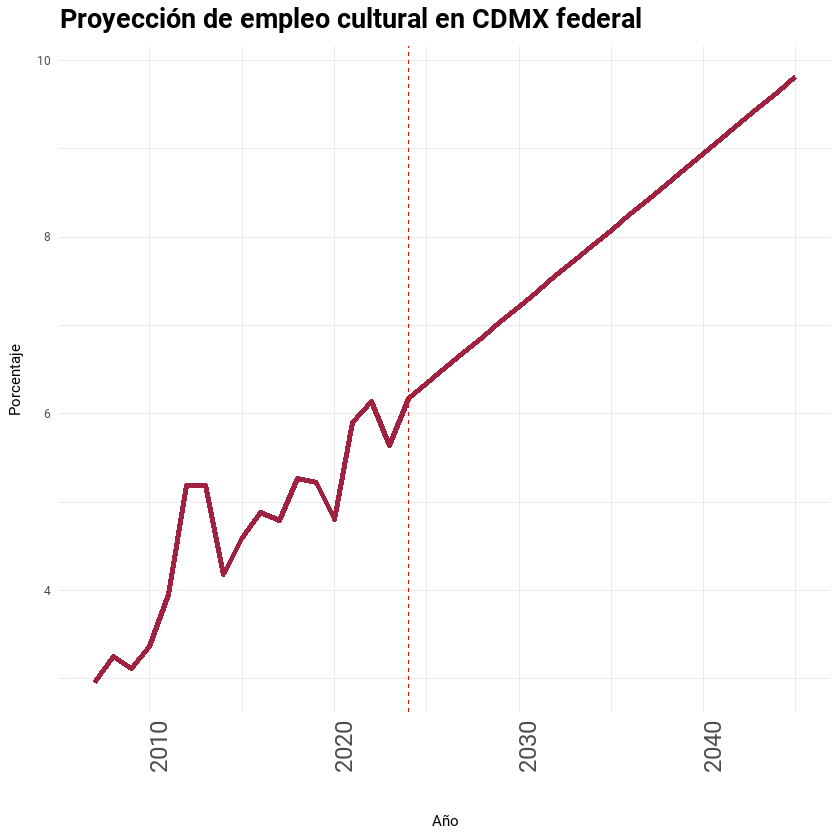

In [16]:
predecir_empleo_cultural(empleo_cultural_federal, "Proyección de empleo cultural en CDMX federal", "proyeccion_empleo_federal.png")